In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style('white')
sns.set_context('poster')


# Solutions: Model Validation and Optimization
For some introduction, please see notebook 1. This notebook assumes some acquintance with the scikit-learn API. Much of the material here is adapted from [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) by Jake VanderPlas and a [workshop at SciPY 2016](https://github.com/amueller/scipy-2016-sklearn) by Sebastian Raschka and Andreas Mueller.

We have been using train_test_split already to divide data between a training set to train the data and a test set to have an independent check of the trained model. In practice, you could imagine that sometimes, by pure chance, your crazy outliers will be in the test set, bringing your test score down, while in another random realization of the train_test_split this is not the case. You could wrongfully conclude you're overfitting.

In order to keep all this all under control, machine learners often use k-fold cross validation. In the k folds, a fraction 1/k of the train data is used for testing and (1-1/k) for training. That is repeated k times. All data points are in the "test" set (in this case, it's called the validation set) exactly once, and k values of the test score (on the 'real' test data).

Mostly to get some insight into the methods, we will simply create some cross-validation by hand. For now, forget about splitting training and testing first and using validation, but just do the cross validation using the whole iris data set as training set. Load the data and train a kNN classifier  using 5-fold cross-validation, without making use of the sklearn.model_selection stuff. What are the scores, and their mean and standard deviation?

Now that you know what is done, let's introduce sklearn's function for doing cross-validation:

In [2]:
from sklearn.model_selection import cross_val_score

Try it! How many folds did it use? You can control that. Try reproducing your own result.

There are a few more objects to import for cross-validation:

In [3]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit

All these are made to make your life easier. The function cross_val_score uses StratifiedKFold, which ensures that the target values are present in the same proportions in all subsamples. Please compare KFold and StratifiedKFold on the un-shuffled iris data set. Would there ever be a reason to use non-stratified?

## Model optimization: taming the hyperparameters

Many, in fact almost all, machine learning models come with a suite of hyperparameters that control the behavior of the algorithm. Sometimes just a few are important, sometimes more. Sometimes one particular set of parameters, sometimes another. At some point you might develop some sort of intuition because you know the model well, and you understand your data, and you might naturally pick a decent value. Before that time (and to be sure, also at that time), you might want to search parameter space for the optimal set of hyperparameters for the current combination of algorithm and data.


### Validation and learning curves

As an example of how to use validation and learning curves, we will create a data set and do polynomial regression. Polynomial regression is not a model in sklearn, but it turns out to be easy to do, using one of the data preprocessing methods (it will become linear regression to polynomial combinations of the features):


In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [5]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

Here is what it looks like, together with three polynomial fits:

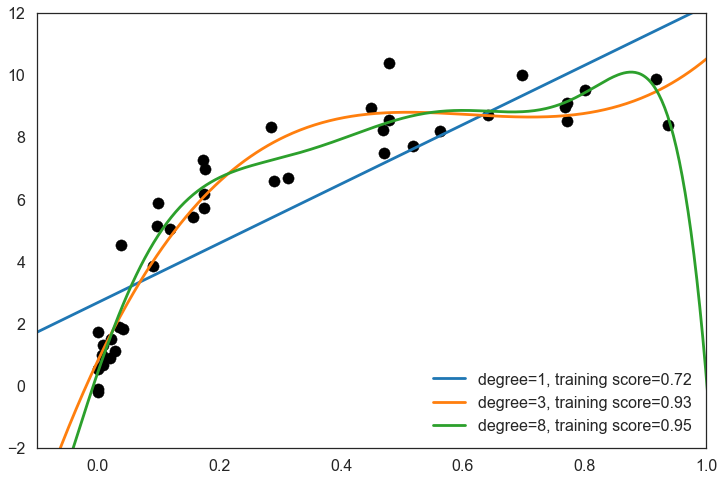

In [6]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.figure(figsize=(12,8))
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 8]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}, training score={1:.2f}'.format(
        degree, PolynomialRegression(degree).fit(X, y).score(X, y)))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='lower right');

Use sklearn.learning_curve.validation_curve to create the validation curves for this model, where the complexity parameter is the degree of polynomial. 

The validation curve needs to pass the polynomial degree to PolynomialFeatures. The pipeline automatically generates the name of this parameter: 'polynomialfeatures\_\_degree'.

What is the optimal degree for fitting and how do you know?

Is this a high bias or a high variance model?

How does a nearest neighbor regressor compare?

While validation curves look at the scores and their dependence on model complexity, learning curves investigate the dependence of both scores on the training set size.

Why would need that is illustrated here. Use the same data set generator to make a sample that has 5 times more data points than the previous. While the model before started overfitting at roughly a twelfth-order polynomial, what is that like for this bigger data set? Use sklearn.model_selection.learning_curve to compare learning curves for a low and a high order polynomial, in the original, 40-point data set. Can you understand the results?

With the same code as above run on X2, y2, you should find that overfitting occurs at much higher order polynomials. In the analysis below, also look at the variation with the number of folds!

### Grid search

In practice, you will want to search a multi-dimensional grid of (hyper-)parameters to find your best model. Obviously, sklearn provides you with an easy interface to do just that: sklearn.model_selection.GridSearchCV. Us that, and its documentation to perform a grid search optimization of the iris data classifier that we started this notebook with. For that one, the number of neihgbors would be a reasonable parameter to play with. Try at least that, and if you can think of more, please go ahead. Cross-validate.

What are the parameters of the best model? What is it's score? How can you make a script that after a grid search uses the best model of teh script to evaluate new data?

## Bonus exercise: text analytics and spam detection

If you have some time left, are looking for something more fun or challenging or if you cheated your way through the solutions to get here at high speed, you may find this extra exercise amusing. It has no solutions, so you will have to do stuff yourself.

There is a dataset included that contains a bunch of emails that are hand-classified to be either spam, or ham. Here is an outline of what needs to be done, with some hints, to get to a spam filter for this data set.

- Read the data set. This is done for you, so as to avoid confusion.
- Labels are fine. Words as features are not yet in great shape to run a classifier on. They will need to be transformed into numeric features. This comes down to counting words. Look for CountVectorizer and TfidfVectorizer to do so. What does this result in? What's the dimensionality of your problem? What does that imply for models?
- Train a classifier of your choice. Investigate a few. Go through hyperparmeters of the classifier, but also of the vectorizers (mostly min_df and ngram_range).
- Experiment with feature engineering. For example (but you should definitely feel free to come up with something yourself, coming up with things is aided by visualisation): length of the email.

How pure can you get the detection (on data the classifier hasn't seen during training)? Can you identify words that are crucial in spam detection? 

Enjoy!

In [93]:
with open(os.path.join("data", "SMSSpamCollection")) as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

text = [x[1] for x in lines]
y = [int(x[0] == "spam") for x in lines]
print("Labels are 0 for ham, 1 for spam!")
print()
print("Example, the first message is", lines[0][0], ":", text[0])
print("Example, the third message is", lines[2][0], ":", text[2])

Labels are 0 for ham, 1 for spam!

Example, the first message is ham : Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Example, the third message is spam : Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
